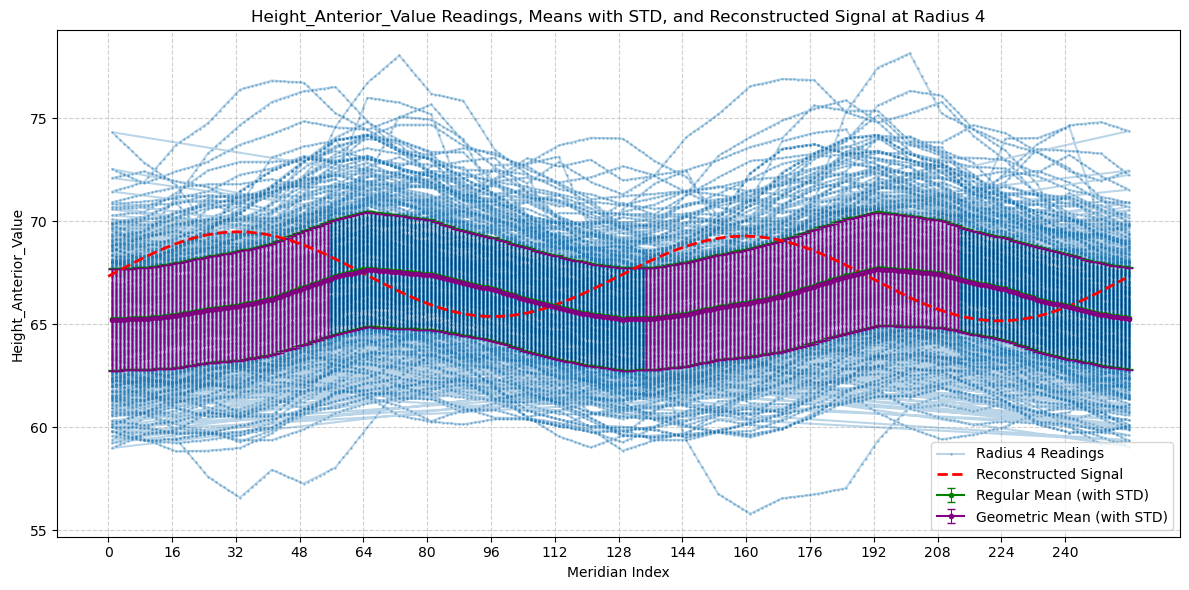

In [13]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

# --- File paths and parameters ---
folder_path = "/home/aricept094/mydata/sheets/combined_data"
radius_of_interest = 4

# --- Reconstructed Signal 1 parameters ---
dc_component_1 = 66.57227822
component_1_amplitude_1 = 0.148765228330431
component_2_amplitude_1 = 2.05532480462519
higher_order_amplitude_sum_1 = 0.761204668465293


# --- Function to calculate geometric mean ---
def geometric_mean(data):
    """Calculates the geometric mean of a pandas Series."""
    a = np.log(data)
    return np.exp(a.mean())

# --- Function to reconstruct signal from Fourier components ---
def reconstruct_signal(meridian_indices, dc_component, component_1_amplitude, component_2_amplitude, higher_order_amplitude_sum):
    """Reconstructs a signal using the given Fourier components."""
    signal = dc_component
    signal += component_1_amplitude * np.sin(1 * np.deg2rad(meridian_indices * (360/256))) # Assuming component 1 is frequency 1
    signal += component_2_amplitude * np.sin(2 * np.deg2rad(meridian_indices * (360/256))) # Assuming component 2 is frequency 2
    # You can include higher order components here if you have their frequencies and amplitudes.
    # For now, adding higher_order_amplitude_sum as a constant offset (simplification)
    signal += higher_order_amplitude_sum
    return signal


# --- Load and process data ---
all_files = glob.glob(os.path.join(folder_path, "*.csv"))
all_dfs = []

for f in all_files:
    df = pd.read_csv(f)
    all_dfs.append(df)

combined_df = pd.concat(all_dfs, ignore_index=True)

# Filter data for radius 4
radius_4_df = combined_df[combined_df['Radial_Index'] == radius_of_interest].copy() # Use .copy() to avoid SettingWithCopyWarning


# --- Calculate means and std for each meridian at radius 4 ---
if not radius_4_df.empty:
    mean_values = radius_4_df.groupby('Meridian_Index')['Height_Anterior_Value'].agg(['mean', geometric_mean, 'std']).reset_index()
    mean_values.rename(columns={'mean': 'Regular Mean', 'geometric_mean': 'Geometric Mean', 'std': 'Standard Deviation'}, inplace=True)


    # --- Create Plot 2: Radius 4 Readings with Reconstructed Signal AND Mean Plots with STD ---
    plt.figure(figsize=(12, 6))
    plt.plot(radius_4_df['Meridian_Index'], radius_4_df['Height_Anterior_Value'], label=f'Radius {radius_of_interest} Readings', linestyle='-', marker='.', markersize=2, alpha=0.3) # reduced alpha for readings

    # Plot Regular Mean with STD error bars
    plt.errorbar(mean_values['Meridian_Index'], mean_values['Regular Mean'],
                 yerr=mean_values['Standard Deviation'],
                 label='Regular Mean (with STD)',
                 linestyle='-', marker='o', markersize=3, color='green',
                 capsize=3, elinewidth=0.8) # Added error bars

    # Plot Geometric Mean with STD error bars
    plt.errorbar(mean_values['Meridian_Index'], mean_values['Geometric Mean'],
                 yerr=mean_values['Standard Deviation'], # Using same STD for both means for simplicity - could calculate geom std if needed
                 label='Geometric Mean (with STD)',
                 linestyle='-', marker='o', markersize=3, color='purple',
                 capsize=3, elinewidth=0.8) # Added error bars


    # Generate reconstructed signal 1
    meridian_indices_reconstruct = np.arange(0, 256)
    reconstructed_signal_values_1 = reconstruct_signal(meridian_indices_reconstruct,
                                                      dc_component_1,
                                                      component_1_amplitude_1,
                                                      component_2_amplitude_1,
                                                      higher_order_amplitude_sum_1)
    plt.plot(meridian_indices_reconstruct, reconstructed_signal_values_1, label='Reconstructed Signal', color='red', linestyle='--', linewidth=2)


    plt.title(f'Height_Anterior_Value Readings, Means with STD, and Reconstructed Signal at Radius {radius_of_interest}')
    plt.xlabel('Meridian Index')
    plt.ylabel('Height_Anterior_Value')
    plt.xticks(np.arange(0, 256, 16)) # Show x-axis ticks every 16 meridians
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print(f"No data found for Radial_Index = {radius_of_interest}")